In [1]:
from typing import List, Dict, Tuple, Callable
import os
import gc
import traceback
import warnings
from pdb import set_trace

import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error as rmse
from sklearn.metrics import mean_squared_error as mse

In [2]:
cars_df = pd.read_csv("car_info_prices.csv")
cars_df.info()
cars_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94256 entries, 0 to 94255
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   year        94256 non-null  int64  
 1   price       94256 non-null  int64  
 2   mileage     94256 non-null  int64  
 3   tax         94256 non-null  int64  
 4   mpg         94256 non-null  float64
 5   engineSize  94256 non-null  float64
dtypes: float64(2), int64(4)
memory usage: 4.3 MB


,year,price,mileage,tax,mpg,engineSize
count,94256.000000,94256.000000,94256.000000,94256.000000,94256.000000,94256.000000
mean,2017.069311,16777.888718,23209.650049,120.116491,55.228326,1.665003
std,2.107498,9879.543183,21055.158586,63.392410,16.296400,0.559244
min,1970.000000,450.000000,1.000000,0.000000,0.300000,0.000000
25%,2016.000000,9999.000000,7670.000000,125.000000,47.100000,1.200000
50%,2017.000000,14480.000000,17673.000000,145.000000,54.300000,1.600000
75%,2019.000000,20766.000000,32497.250000,145.000000,62.800000,2.000000
max,2024.000000,159999.000000,323000.000000,580.000000,470.800000,6.600000


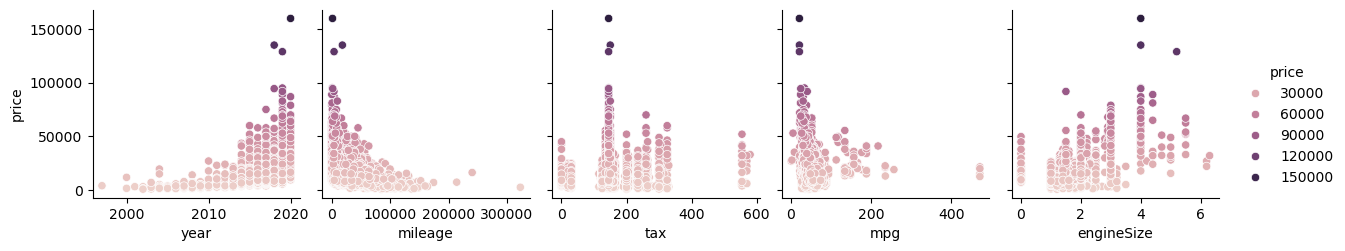

In [30]:
import seaborn as sns

rng = np.random.RandomState(0)
indices = rng.choice(np.arange(len(cars_df)), size = 15000, replace = False)
sns.pairplot(
    data = cars_df.iloc[indices],
    y_vars = ['price'],
    x_vars = list(cars_df.drop(columns = ['price']).columns),
    hue = "price"
)

cars_df = cars_df.iloc[indices]
plt.show()

In [4]:
def get_train_valid_test_data(
    X: np.ndarray, 
    y: np.ndarray, 
):
    """ Randomizes and then splits the data into train, validation, and test sets.

        Args:
            X: Data given as a 2D matrix

            y: Labels given as a vector 
    """
    assert isinstance(X, np.ndarray), f'`X` must be a NumPy array, got type {type(X)} instead.'
    assert isinstance(y, np.ndarray), f'`y` must be a NumPy array, got type {type(y)} instead.'
    X_trn, X_tst, y_trn, y_tst = train_test_split(X, y, train_size=.8, random_state=42)
    X_trn, X_vld, y_trn, y_vld = train_test_split(X_trn, y_trn, train_size=.8, random_state=42)

    return X_trn, y_trn, X_vld, y_vld, X_tst, y_tst

In [5]:
def get_preprocessed_data() -> Tuple[np.ndarray, ...]:
    """ Gets preprocessed data for training, validation, and testing

        Return:
            A tuple of NumPy arrays where indices 0-1 
            contain the training data/targets, indices 2-3
            contain the validation data/targets, and 4-5
            contain the testing data/targets.
    """
    X_trn, y_trn, X_vld, y_vld, X_tst, y_tst = None, None, None, None, None, None

    X = cars_df.drop("price", axis = 1)
    y = cars_df["price"]
    X = X.to_numpy()
    y = y.to_numpy()

    X_trn, y_trn, X_vld, y_vld, X_tst, y_tst = get_train_valid_test_data(X, y)

    scaler = StandardScaler()
    scaler = scaler.fit(X_trn)

    X_trn = scaler.transform(X_trn)
    X_vld = scaler.transform(X_vld)
    X_tst = scaler.transform(X_tst)

    return X_trn, y_trn.reshape(-1, 1), X_vld, y_vld.reshape(-1, 1), X_tst, y_tst.reshape(-1, 1)

In [6]:
class Linear():
    @staticmethod
    def activation(z: np.ndarray) -> np.ndarray:
        """ Computes the output of the linear activation function """
        
        return z
    
    @staticmethod
    def derivative(z: np.ndarray) -> np.ndarray:
        """ Computes the derivative for the linear activation function """
        
        return np.ones(z.shape)

In [7]:
class Tanh():
    """ The tanh actionvation function """
    @staticmethod
    def activation(z: np.ndarray) -> np.ndarray:
        """ Computes the output of the tanh activation function """
        
        return np.tanh(z)

    @staticmethod
    def derivative(z: np.ndarray) -> np.ndarray:
        """ Computes the derivative of the tanh activation function """
        
        return 1 - np.tanh(z) ** 2

In [8]:
def init_weights(
    m_input_features: int, 
    hidden_neurons: int, 
    output_neurons: int, 
) -> Tuple[np.ndarray, ...]:
    """ Initilize the hidden and output layer parameters
        
        Args:
            m_input_features: The number of input features

            hidden_neurons: The number of hidden neurons or units to 
                use in the hidden layer.

            output_neurons: The number of output neurons to use in 
                the output layer.

        Returns:
            A tuple of NumPy arrays containing the weights and biases
            for the hidden and output layers.
    """
    
    W1 = np.random.uniform(-0.5, 0.5, size = (m_input_features, hidden_neurons))
    b1 = np.ones((1, hidden_neurons))
    
    W2 = np.random.uniform(-0.5, 0.5, size = (hidden_neurons, output_neurons))
    b2 = np.ones((1, output_neurons))
    
    return W1, b1, W2, b2

In [9]:
def forward(
    X: np.ndarray, 
    W1: np.ndarray, 
    b1: np.ndarray,
    W2: np.ndarray, 
    b2: np.ndarray, 
) -> Tuple[np.ndarray, ...]:
    """ Forward pass for 2 layer neural network
    
        Args:
            X: Input features
            
            W1: Hidden layer weights 
            
            b1: Hidden layer biases

            W2: Output layer weights 
            
            b2: Output layer biases

        Returns:
            A tuple of NumPy arrays containing the linear combination and 
            acitvation outputs for each layer. These are needed to compute 
            the backward pass.
    """
    Z1, A1, Z2, A2 = None, None, None, None

    Z1 = X @ W1 + b1
    A1 = Tanh.activation(Z1)

    Z2 = A1 @ W2 + b2
    A2 = Linear.activation(Z2)
    
    return Z1, A1, Z2, A2

In [10]:
def output_layer_grads(
    X: np.ndarray,
    y: np.ndarray,
    W1: np.ndarray,
    Z1: np.ndarray,
    A1: np.ndarray,
    W2: np.ndarray,
    Z2: np.ndarray,
    A2: np.ndarray
) -> Tuple[np.ndarray, np.ndarray]:
    """ Compute gradients for the output layer parameters
    
        Args:
            X: Input data given as a matrix
            
            y: Ground truth labels given as a column vector

            W1: Hidden layer weights
            
            Z1: Linear combination output for hidden layer

            A1: Activation output for hidden layer
            
            W2: Output layer weights

            Z2: Linear combination output for the output layer

            A2: Activation output or the output layer. Also 
                referred to as y_hat.
            
        Return:
            A tuple of NumPy arrays containing the average gradient 
            for the output layer weights and biases.
    """

    W2_avg_grad = (A1.T @ ((A2 - y) * Linear.derivative(Z2))) / len(X)

    b2_avg_grad = (np.ones([len(X), 1]).T @ ((A2 - y) * Linear.derivative(Z2))) / len(X)
    
    return W2_avg_grad, b2_avg_grad

In [11]:
def hidden_layer_grads(
    X: np.ndarray,
    y: np.ndarray,
    W1: np.ndarray,
    Z1: np.ndarray,
    A1: np.ndarray,
    W2: np.ndarray,
    Z2: np.ndarray,
    A2: np.ndarray
) -> Tuple[np.ndarray, np.ndarray]:
    """ Compute gradients for the hidden layer parameters
    
        Args:
            X: Input data given as a matrix
            
            y: Ground truth labels given as a column vector

            W1: Hidden layer weights
            
            Z1: Linear combination output for hidden layer

            A1: Activation output for hidden layer
            
            W2: Output layer weights

            Z2: Linear combination output for the output layer

            A2: Activation output or the output layer. Also 
                referred to as y_hat.
            
        Return:
            A tuple of NumPy arrays containing the average gradient 
            for the hidden layer weights and biases.
    """

    W1_avg_grad = (X.T @ ((A2 - y) * np.ones([len(X), 1]) @ W2.T * Tanh.derivative(Z1))) / len(X)

    b1_avg_grad = (np.ones([len(X), 1]).T @ ((A2 - y) * np.ones([len(X), 1]) @ W2.T * Tanh.derivative(Z1))) / len(X)
    
    return W1_avg_grad, b1_avg_grad

In [12]:
def get_batches(
    data_len: int, 
    batch_size: int = 32,
) -> List[np.ndarray]:
    """ Generates mini-batches based on the data indexes
        
        Args:
            data_len: Length of the data or number of data samples 
                in the data. This is used to generate the indices of
                the data.
            
            batch_size: Size of each mini-batch where the last mini-batch
                might be smaller than the rest if the batch_size does not 
                evenly divide the data length.

        Returns:
            A list of NumPy array's holding the indices of batches
    """
    indices = np.arange(data_len)
    np.random.shuffle(indices)
    batches = [indices[i:i + batch_size] for i in range(0, data_len, batch_size)]

    return batches

In [13]:
class NeuralNetwork():
    def __init__(self,
        hidden_neurons: int,
        output_neurons: int,
        alpha: float, 
        batch_size: int,
        epochs: int = 1,
        seed: int = 0,
    ):
        """ A two layer neural network using SGD
            
            Attributes:
                hidden_neurons: Number of hidden units/neurons.
                
                output_neurons: Number of output neuorns
                
                alpha: learning rate or step size.
                
                batch_size: Size of mini-batches for mini-batch gradient
                    descent.
                
                epochs: Number of epochs to run for mini-batch
                    gradient descent.
                    
                seed: Seed to be used for NumPy's np.random.seed() function.
    
                W1: Hidden layer weights with shape (inputs, neurons)
                
                b1: Hidden layer baises with shape (1, neurons)
                
                W2: Output layer weights with shape (inputs, neurons)
                
                b2: Output layer baises with shape (1, neurons)
    
                trn_error: Stores the training error for each epoch.
    
                vld_error: Stores the validation error for each epoch.
        """
        self.hidden_neurons = hidden_neurons
        self.output_neurons = output_neurons
        self.batch_size = batch_size
        self.alpha = alpha
        self.epochs = epochs
        self.seed = seed
        
        self.W1, self.b1 = None, None
        self.W2, self.b2 = None, None
        self.trn_error = None
        self.vld_error = None

    def fit(
        self,
        X: np.ndarray, 
        y: np.ndarray,
        X_vld: np.ndarray = None, 
        y_vld:np.ndarray = None,
    ): 
        """ Trains a basic two layer neural network using SGD
        
            Args:
                X: Training data given as a 2D matrix

                y: Training labels given as a 2D column vector

                X_vld: Validation data given as a 2D matrix. Used 
                    to compute the validation RMSE for each epoch.

                y_vld: Validation labels given as a 2D matrix. Used 
                    to compute the validation RMSE for each epoch.
        """
        np.random.seed(self.seed)
        self.trn_error = []
        self.vld_error = []
        
        self.W1, self.b1, self.W2, self.b2 = init_weights(X.shape[1], self.hidden_neurons, self.output_neurons)

        for e in range(self.epochs):
            batches = get_batches(len(X), self.batch_size)
            for b in batches:
                Z1, A1, Z2, A2 = forward(X = X[b], W1 = self.W1, b1 = self.b1, W2 = self.W2, b2 = self.b2)
                W2_avg_grad, b2_avg_grad = output_layer_grads(X[b], y[b], self.W1, Z1, A1, self.W2, Z2, A2)
                W1_avg_grad, b1_avg_grad = hidden_layer_grads(X[b], y[b], self.W1, Z1, A1, self.W2, Z2, A2)
                self.W2 = self.W2 - self.alpha * W2_avg_grad
                self.b2 = self.b2 - self.alpha * b2_avg_grad
                self.W1 = self.W1 - self.alpha * W1_avg_grad
                self.b1 = self.b1 - self.alpha * b1_avg_grad

            trn_preds = self.predict(X)
            trn_error = rmse(y, trn_preds)
            self.trn_error.append(trn_error)

            if X_vld is not None and y_vld is not None:
                vld_preds = self.predict(X_vld)
                vld_error = rmse(y_vld, vld_preds)
                self.vld_error.append(vld_error)
    
        return self
    
    def predict(self, X: np.ndarray):
        """ Make predictions using forward pass.

            Args:
                X: Testing data given as a 2D matrix

            Returns:
                A 2D column vector of predictions for each data sample in X
        """
        
        Z1, A1, Z2, A2 = forward(X = X, W1 = self.W1, b1 = self.b1, W2 = self.W2, b2 = self.b2)
        
        return A2

Train MSE: 24445074.657621183
Train RMSE: 4944.196057765224
Validation MSE: 25889451.184193943
Validation RMSE: 5088.167762976565
Test MSE: 26492267.696017582
Test RMSE: 5147.06398794668


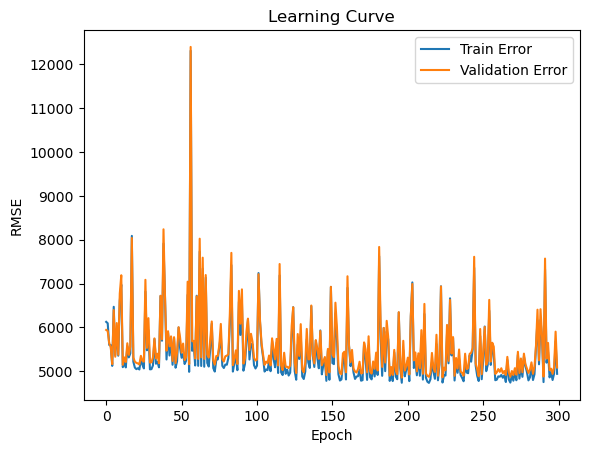

In [79]:
nn = NeuralNetwork(hidden_neurons = 50, output_neurons = 1, batch_size = 70, alpha = 0.06, epochs = 300, seed = 42)
X_trn, y_trn, X_vld, y_vld, X_tst, y_tst = get_preprocessed_data()
nn = nn.fit(X_trn, y_trn, X_vld = X_vld, y_vld = y_vld)

y_hat_trn = nn.predict(X_trn)
trn_mse_score = mse(y_trn, y_hat_trn)
trn_rmse_score = rmse(y_trn, y_hat_trn)
print(f"Train MSE: {trn_mse_score}")
print(f"Train RMSE: {trn_rmse_score}")
    
y_hat_vld = nn.predict(X_vld)
vld_mse_score = mse(y_vld, y_hat_vld)
vld_rmse_score = rmse(y_vld, y_hat_vld)
print(f"Validation MSE: {vld_mse_score}")
print(f"Validation RMSE: {vld_rmse_score}")

y_hat_tst = nn.predict(X_tst)
tst_mse_score = mse(y_tst, y_hat_tst)
tst_rmse_score = rmse(y_tst, y_hat_tst)
print(f"Test MSE: {tst_mse_score}")
print(f"Test RMSE: {tst_rmse_score}")

plt.plot(nn.trn_error, label = 'Train Error')
plt.plot(nn.vld_error, label = 'Validation Error')
plt.title("Learning Curve")
plt.ylabel("RMSE")
plt.xlabel("Epoch")
plt.legend()
plt.show()